# importing acl-anthology bib file & creating csv

In [1]:
import requests
import gzip
import shutil
import os

# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [2]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [3]:
import pandas as pd

# define keywords & words to exclude
keywords = ['fair', 'fairness', 'race', 'gender', 'bias', 'biases', 'protected attribute', 'protected categor']
excludes = ['hate', 'hate speech']
df = pd.DataFrame()

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            if not any(exclude in paper['abstract'] for exclude in excludes):
                temp_row = {}

                # select only select papers from 2016 on
                if 'year' in paper.keys() and int(paper['year']) >= 2016:

                    for cat in paper.keys():
                        temp_row[cat] = paper[cat]

                    df = df.append(temp_row, ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [ ]:
# uncomment if csv is already in directory (and save time parsing the bib file)
# df = pd.read_csv('bias_paper.csv')

# tf-idf & clustering

In [4]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [5]:
import re
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")
    #stopwords_list.extend(['approach', 'bias', 'biases', 'data', 'fair', 'fairness', 'human', 
     #                      'language', 'languages', 'method', 'paper', 'task', 'tasks', 'well', 'word',
      #                    'words'])

    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords_list]
        text = " ".join(tokens)
    
    text = text.lower().strip()
    
    return text

In [6]:
# create cleaned column
df['cleaned'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned'])

In [118]:
from sklearn.cluster import KMeans

# vary here the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [119]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [120]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [121]:
import numpy as np

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(20)


Cluster 0
research,nlp,experiments,art,trained,corpus,analysis,existing,used,new,knowledge,set,natural,state,approach,method,evaluation,human,information,systems

Cluster 1
new,method,large,trained,nlp,user,analysis,across,biased,research,words,information,study,used,detection,corpus,news,media,embeddings,social

Cluster 2
proposed,test,one,trained,context,used,sentence,method,approach,problem,information,system,human,evaluation,languages,quality,systems,english,machine,translation


In [122]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               #3: "cluster 04", 
               #4: "cluster 05", 
               #5: "cluster 06", 
               #6: "cluster 07", 
               #7: "cluster 08", 
               #8: "cluster 09", 
               #9: "cluster 10"
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

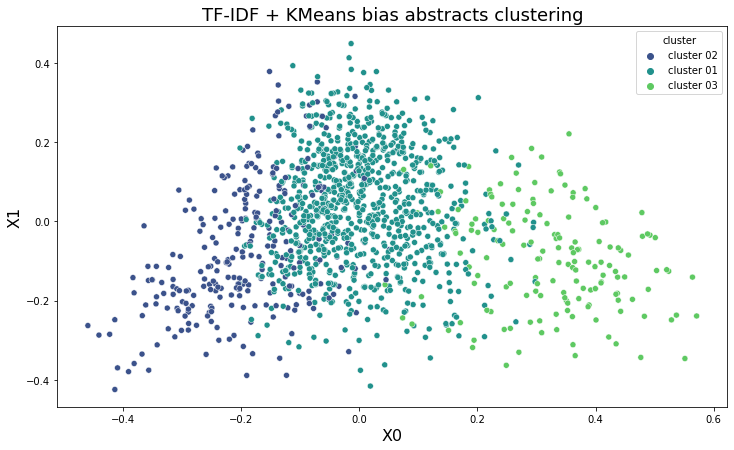

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# set image size
plt.figure(figsize=(12, 7))
plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

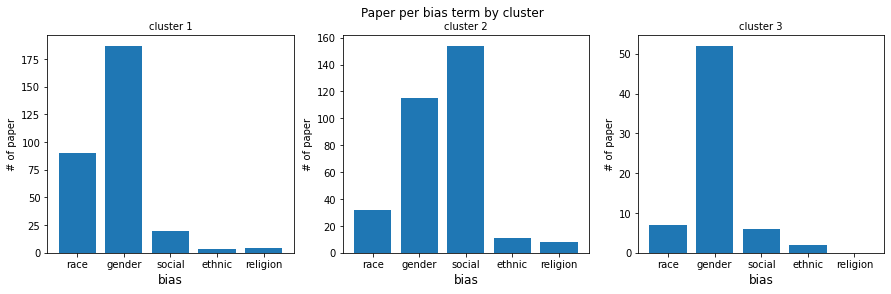

In [124]:
fig, ax = plt.subplots(1, kmeans.n_clusters, figsize=(15,4))
bias_list = ['race', 'gender', 'social', 'ethnic', 'religion']

for i in range(kmeans.n_clusters):
    bias_counts = {}
    for j in bias_list:
        temp_df = df.loc[df['cluster'] == 'cluster 0{}'.format(i+1)]
        bias_counts[j] = temp_df['cleaned'].str.contains(j).sum()
    
    ax[i].set_title("cluster {}".format(i+1), fontdict={"fontsize": 10})
    ax[i].set_xlabel("bias", fontdict={"fontsize": 12})
    ax[i].set_ylabel("# of paper")
        
    keys = bias_counts.keys()
    values = bias_counts.values()
    ax[i].bar(keys, values);

fig.suptitle('Paper per bias term by cluster')
plt.show();

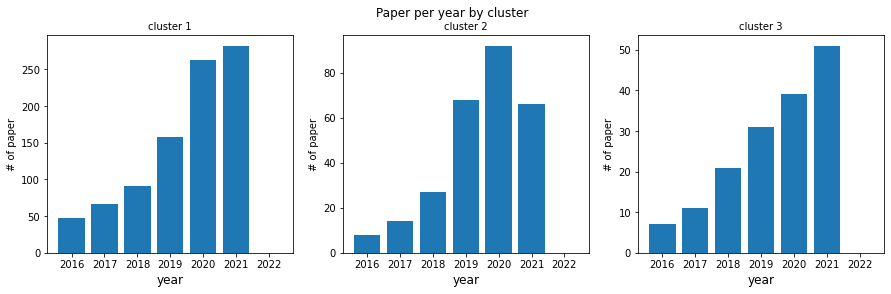

In [125]:
fig, ax = plt.subplots(1, kmeans.n_clusters, figsize=(15,4))
year_list = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']

for i in range(kmeans.n_clusters):
    bias_counts = {}
    for j in year_list:
        temp_df = df.loc[df['cluster'] == 'cluster 0{}'.format(i+1)]
        bias_counts[j] = temp_df['year'].str.contains(j).sum()
    
    ax[i].set_title("cluster {}".format(i+1), fontdict={"fontsize": 10})
    ax[i].set_xlabel("year", fontdict={"fontsize": 12})
    ax[i].set_ylabel("# of paper")
        
    keys = bias_counts.keys()
    values = bias_counts.values()
    ax[i].bar(keys, values);

fig.suptitle('Paper per year by cluster')
plt.show();

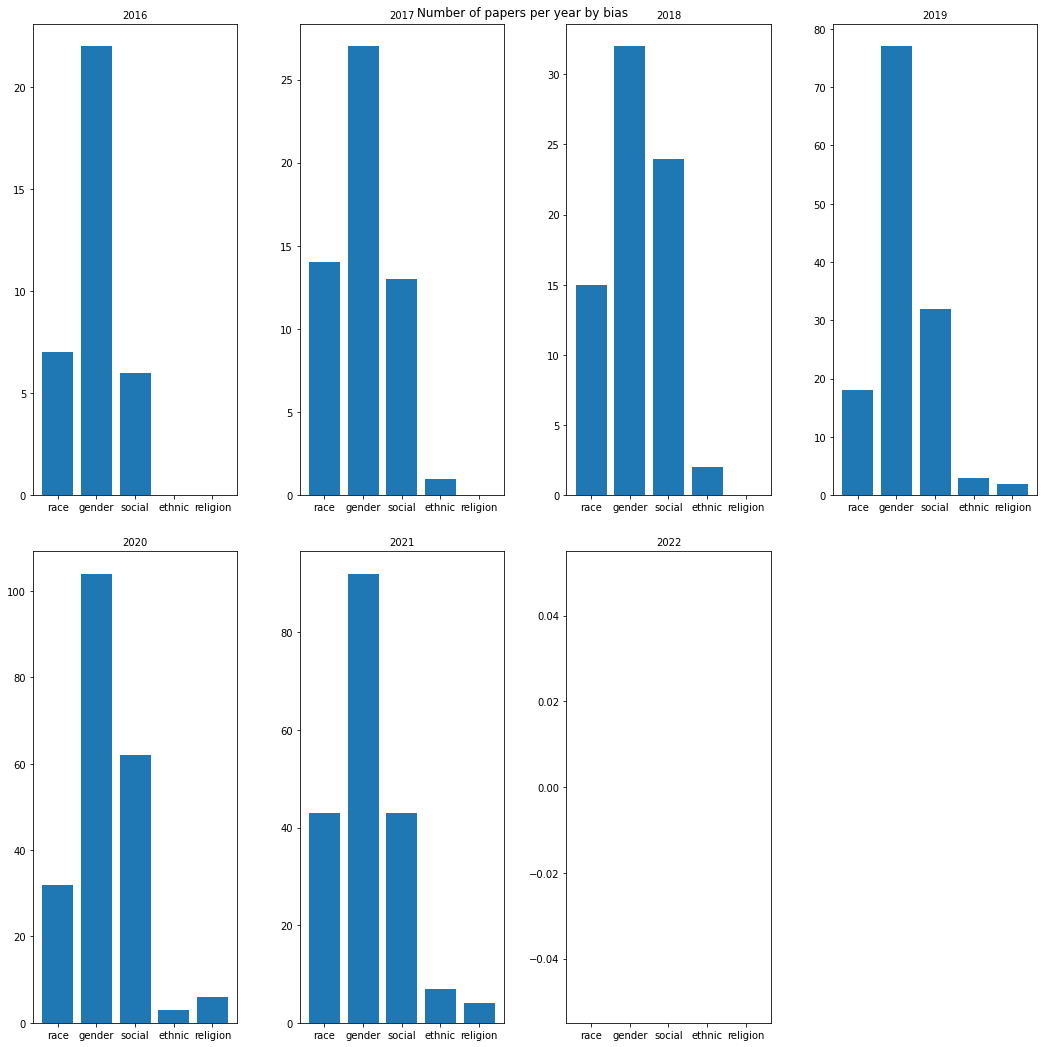

In [117]:
year_list = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']
bias_list = ['race', 'gender', 'social', 'ethnic', 'religion']

nrows, ncols = 2, 4
fig = plt.figure() 

for i in range(1, len(year_list)+1):
    bias_counts = {}
    for j in bias_list:
        temp_df = df.loc[df['year'] == year_list[i-1]]
        bias_counts[j] = temp_df['cleaned'].str.contains(j).sum()
        
    ax = fig.add_subplot(nrows, ncols, i)            
    ax.set_title("{}".format(year_list[i-1]), fontdict={"fontsize": 10})
    #ax.set_xlabel("bias", fontdict={"fontsize": 12})
    #ax.set_ylabel("# of paper")
        
    keys = bias_counts.keys()
    values = bias_counts.values()
    ax.bar(keys, values);

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=2.5)
fig.suptitle('Number of papers per year by bias')
plt.show();